In [94]:
import numpy as np
import hls4ml
import os
import pandas
import matplotlib.pyplot as plt
import BelleII_CNN 
import tensorflow.compat.v2 as tf
import os
import qkeras
from tensorflow import keras
import plotting

os.environ['PATH'] = '/tools/xilinx/ISE_EDK/Vivado/2019.2/bin:' + os.environ['PATH']

## HLS4ml CNN runs


### Define dataset

In [8]:
X,Y = np.load("/home/updyh/DataSet/master_row_hits.npy"), np.load("/home/updyh/DataSet/master_row_hits_vertex.npy")
print("Dataset Loaded ! \n")
print(f"Dataset shape is {X.shape}, Label shape is {Y.shape} ")

Dataset Loaded ! 

Dataset shape is (45484, 14336), Label shape is (45484, 2) 


In [13]:
FPGA_image_converter_ins = BelleII_CNN.FPGA_hit_image_converter()
HIT_IMAGES = FPGA_image_converter_ins.convert_frame_batch(X)
print(HIT_IMAGES.shape)

(45484, 56, 160)


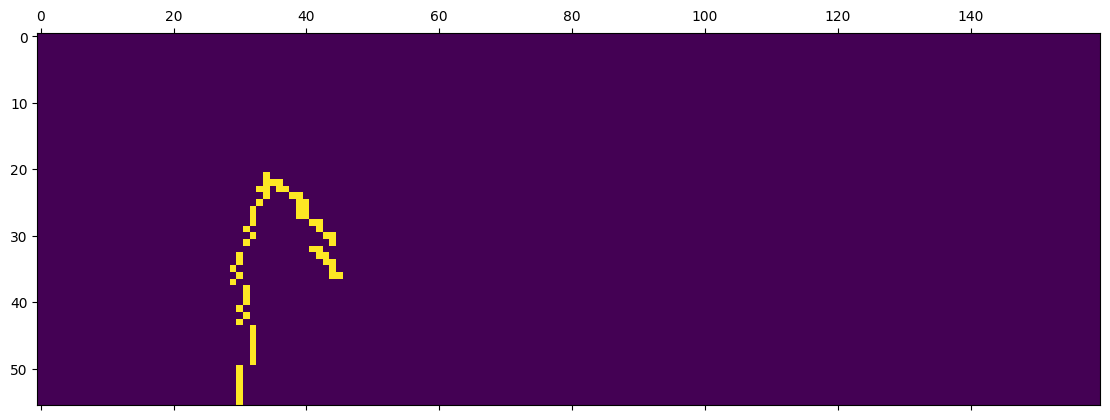

In [14]:
plt.matshow(HIT_IMAGES[1])
plt.show()

In [36]:
HIT_IMAGES = HIT_IMAGES.reshape((HIT_IMAGES.shape[0],56,160,1 ))
print(HIT_IMAGES.shape)

(45484, 56, 160, 1)


## Create our Standard vertex model and Qmodel here

In [58]:
def create_vertex_cnn(
             
    input_shape = (56,200,1),             
    output_size = 2,
    filters_per_conv_layer = [], # int in list
    kernels_per_conv_layer = [], # tuple in list
    strides_per_conv_layer = [], # tuple in list
    poolsize_per_conv_layer = [],# tuple in list
    neurons_per_dense_layer = [] # int in list
):

    # Input Layer
    x = x_in = keras.layers.Input(input_shape)
    
    # Conv Block
    for layer,filters in enumerate(filters_per_conv_layer):
        
        filter_num = filters
        filter_kernel_size = kernels_per_conv_layer[layer]
        filter_strides = strides_per_conv_layer[layer]
        poolsize = poolsize_per_conv_layer[layer]

        x = keras.layers.Conv2D(filter_num,
                                filter_kernel_size,
                                strides = filter_strides,
                                kernel_initializer = "lecun_uniform",
                                #kernel_regularizer = l1(0.0001),
                                use_bias = False,
                                name = f"conv_{layer}"
                               )(x)
        x = keras.layers.BatchNormalization(name = f"conv_bn_{layer}")(x)
        x = keras.layers.Activation("relu",name = f"conv_act_{layer}")(x)
        x = keras.layers.AveragePooling2D(pool_size=poolsize,name = f"conv_pool_{layer}")(x)
        
    
    # Flatten layer    
    x = keras.layers.Flatten()(x)
    
    # Dense Block
    for layer,neurons in enumerate(neurons_per_dense_layer):

        x = keras.layers.Dense(neurons,
                               kernel_initializer = "lecun_uniform",
                               #kernel_regularizer = l1(0.0001),
                               name = f"dense_{layer}",
                               use_bias = True)(x)
        x = keras.layers.BatchNormalization(name = f"dense_bn_{layer}")(x)
        x = keras.layers.Activation("relu",name = f"dense_act_{layer}")(x)
    
    # Output Dense layer
    x_out = x = keras.layers.Dense(output_size,name = "dense_output")(x)
    model = keras.models.Model(inputs = x_in,
                               outputs = x,
                               )
    return model    

def create_vertex_Qcnn(
             
    input_shape = (56,200,1),             
    output_size = 2,
    
    filters_per_conv_layer = [], # int in list
    kernels_per_conv_layer = [], # tuple in list
    strides_per_conv_layer = [], # tuple in list
    poolsize_per_conv_layer = [],# tuple in list
    
    neurons_per_dense_layer = [], # int in list,
    
    bit_width = 15,
    int_width = 8
):

    # Input Layer
    x = x_in = keras.layers.Input(input_shape)
    
    # Conv Block
    for layer,filters in enumerate(filters_per_conv_layer):
        
        filter_num = filters
        filter_kernel_size = kernels_per_conv_layer[layer]
        filter_strides = strides_per_conv_layer[layer]
        poolsize = poolsize_per_conv_layer[layer]
               
        x = qkeras.QConv2DBatchnorm(filter_num,
                                filter_kernel_size,
                                strides = filter_strides,
                                kernel_initializer = "lecun_uniform",
                                #kernel_regularizer = l1(0.0001),
                                use_bias = False,
                                name = f"conv_{layer}",
                                kernel_quantizer=f"quantized_bits({bit_width},{int_width},alpha=1)", 
                                bias_quantizer=f"quantized_bits({bit_width},{int_width},alpha=1)"
                               )(x)
        x = qkeras.QActivation(f'quantized_relu({bit_width},{int_width})',name = f"conv_act_{layer}")(x)
        x = keras.layers.AveragePooling2D(pool_size=poolsize,name = f"conv_pool_{layer}")(x)
        
    
    # Flatten layer    
    x = keras.layers.Flatten()(x)
    
    # Dense Block
    for layer,neurons in enumerate(neurons_per_dense_layer):

        x = qkeras.QDense(     neurons,
                               kernel_initializer = "lecun_uniform",
                               #kernel_regularizer = l1(0.0001),
                               name = f"dense_{layer}",
                               use_bias = True,
                               kernel_quantizer=f"quantized_bits({bit_width},{int_width},alpha=1)", 
                               bias_quantizer=f"quantized_bits({bit_width},{int_width},alpha=1)")(x)
        #x = keras.layers.BatchNormalization(name = f"dense_bn_{layer}")(x)
        x = qkeras.QActivation(f'quantized_relu({bit_width},{int_width})',name = f"dense_act_{layer}")(x)
    
    # Output Dense layer
    #x_out = x = keras.layers.Dense(output_size,name = "dense_output")(x)
    x_out = x = qkeras.QDense( output_size,
                               kernel_initializer = "lecun_uniform",
                               #kernel_regularizer = l1(0.0001),
                               use_bias = False,
                               kernel_quantizer=f"quantized_bits({bit_width},{int_width},alpha=1)", 
                               bias_quantizer=f"quantized_bits({bit_width},{int_width},alpha=1)",
                               name = "dense_output",)(x)
    model = keras.models.Model(inputs = x_in,
                               outputs = x,
                               name = "Q_model"
                               )
    return model

In [59]:
std_model = create_vertex_cnn(
    # input/output         
    input_shape = (56,160,1),             
    output_size = 2,
    # Conv Block
    filters_per_conv_layer = [1], # int in list
    kernels_per_conv_layer = [(7,7)], # tuple in list
    strides_per_conv_layer = [(2,2)], # tuple in list
    poolsize_per_conv_layer = [(4,4)],# tuple in list
    # Dense Block
    neurons_per_dense_layer = [25,15] # int in list
)
std_model.summary()


Qmodel = create_vertex_Qcnn(
    # input/output         
    input_shape = (56,160,1),             
    output_size = 2,
    # Conv Block
    filters_per_conv_layer = [1], # int in list
    kernels_per_conv_layer = [(7,7)], # tuple in list
    strides_per_conv_layer = [(2,2)], # tuple in list
    poolsize_per_conv_layer = [(4,4)],# tuple in list
    # Dense Block
    neurons_per_dense_layer = [25,15], # int in list
    # Quantization
    bit_width = 16,
    int_width = 8
)
Qmodel.summary()
qkeras.print_qstats(Qmodel)
from qkeras.autoqkeras.utils import print_qmodel_summary
print_qmodel_summary(Qmodel) 

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 56, 160, 1)]      0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 25, 77, 1)         49        
_________________________________________________________________
conv_bn_0 (BatchNormalizatio (None, 25, 77, 1)         4         
_________________________________________________________________
conv_act_0 (Activation)      (None, 25, 77, 1)         0         
_________________________________________________________________
conv_pool_0 (AveragePooling2 (None, 6, 19, 1)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 114)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 25)                2875

In [60]:
for layer in std_model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name,layersize)) # 0 = weights, 1 = biases
        if (layersize > 4096): # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name,layersize))

conv_0: 49
dense_0: 2850
dense_1: 375
dense_output: 30


## STD trainng

In [61]:
std_model.compile(
optimizer=keras.optimizers.Adam(0.0005),
loss = "mse",
metrics=[
        #keras.metrics.MeanSquaredError(),
        #keras.metrics.RootMeanSquaredError(),
        #keras.metrics.MeanAbsoluteError(name="Mean Error in cm", dtype=None),
        keras.metrics.RootMeanSquaredError(name = "Distance Deviation in CM ",)
])

In [71]:
std_model.fit(
#x = x.reshape((x.shape[0],56,160,1)),
#x = fpga_preprocessing(x.reshape((x.shape[0],56,160,1)),fpga_filter_in,[1,4,4,1]),
x = HIT_IMAGES,
y = Y,        
batch_size= 40,
validation_split=0.1,
validation_freq=10,
use_multiprocessing= True,
epochs = 450,
verbose = 1,
#use_multiprocessing=True 
)

Epoch 1/450
1024/1024 [==============================] - 9s 9ms/step - loss: 76.3329 - Distance Deviation in CM : 8.7369
Epoch 2/450
1024/1024 [==============================] - 9s 9ms/step - loss: 77.3163 - Distance Deviation in CM : 8.7930
Epoch 3/450
1024/1024 [==============================] - 9s 9ms/step - loss: 76.2389 - Distance Deviation in CM : 8.7315
Epoch 4/450
1024/1024 [==============================] - 9s 9ms/step - loss: 75.3892 - Distance Deviation in CM : 8.6827
Epoch 5/450
1024/1024 [==============================] - 9s 9ms/step - loss: 76.0677 - Distance Deviation in CM : 8.7217
Epoch 6/450
1024/1024 [==============================] - 9s 9ms/step - loss: 76.7822 - Distance Deviation in CM : 8.7625
Epoch 7/450
1024/1024 [==============================] - 9s 8ms/step - loss: 75.1482 - Distance Deviation in CM : 8.6688
Epoch 8/450
1024/1024 [==============================] - 9s 9ms/step - loss: 76.3425 - Distance Deviation in CM : 8.7374
Epoch 9/450
1024/1024 [=========

### Std model Save

In [72]:
std_model.save("cnn_runs/std_8_3_8_9.h5")

## Load Std model

In [ ]:
std_model = keras.models.load_model("cnn_runs/std_8_7_9_0.h5")


## QAT

In [65]:
Qmodel.compile(
optimizer=keras.optimizers.Adam(0.00002),
loss = "mse",
metrics=[
        #keras.metrics.MeanSquaredError(),
        #keras.metrics.RootMeanSquaredError(),
        #keras.metrics.MeanAbsoluteError(name="Mean Error in cm", dtype=None),
        keras.metrics.RootMeanSquaredError(name = "Distance Deviation in CM ",)
])

In [69]:
Qmodel.fit(
#x = x.reshape((x.shape[0],56,160,1)),
#x = fpga_preprocessing(x.reshape((x.shape[0],56,160,1)),fpga_filter_in,[1,4,4,1]),
x = HIT_IMAGES,
y = Y,        
batch_size= 50,
validation_split=0.1,
validation_freq=10,
use_multiprocessing= True,
epochs = 150,
verbose = 1,
#use_multiprocessing=True 
)

Epoch 1/150
819/819 [==============================] - 10s 13ms/step - loss: 69.0525 - Distance Deviation in CM : 8.3098
Epoch 2/150
819/819 [==============================] - 11s 13ms/step - loss: 68.9926 - Distance Deviation in CM : 8.3062
Epoch 3/150
819/819 [==============================] - 11s 13ms/step - loss: 68.9177 - Distance Deviation in CM : 8.3017
Epoch 4/150
819/819 [==============================] - 12s 14ms/step - loss: 68.9028 - Distance Deviation in CM : 8.3008
Epoch 5/150
819/819 [==============================] - 11s 13ms/step - loss: 68.8639 - Distance Deviation in CM : 8.2984
Epoch 6/150
819/819 [==============================] - 11s 13ms/step - loss: 68.8360 - Distance Deviation in CM : 8.2967
Epoch 7/150
819/819 [==============================] - 11s 14ms/step - loss: 68.7667 - Distance Deviation in CM : 8.2926
Epoch 8/150
819/819 [==============================] - 11s 14ms/step - loss: 68.7291 - Distance Deviation in CM : 8.2903
Epoch 9/150
819/819 [===========

## Save Qmodel

In [70]:
Qmodel.save("cnn_runs/Q_8_0_8_6_ep600_lr2e-5.h5")

## Load Qmodel

In [73]:
path_of_selected_model = "cnn_runs/Q_8_0_8_6_ep600_lr2e-5.h5"

from qkeras.utils import _add_supported_quantized_objects
from qkeras.autoqkeras.utils import print_qmodel_summary
co = {}
_add_supported_quantized_objects(co)
Qmodel = tf.keras.models.load_model(path_of_selected_model ,custom_objects=co)
#Qmodel = tf.keras.models.load_model("runs/Q_Embedding_Model_v2_ap_24_8.h5" ,custom_objects=co)
Qmodel.summary()
qkeras.print_qstats(Qmodel)
print_qmodel_summary(Qmodel) 

Model: "Q_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 56, 160, 1)]      0         
_________________________________________________________________
conv_0 (QConv2DBatchnorm)    (None, 25, 77, 1)         54        
_________________________________________________________________
conv_act_0 (QActivation)     (None, 25, 77, 1)         0         
_________________________________________________________________
conv_pool_0 (AveragePooling2 (None, 6, 19, 1)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 114)               0         
_________________________________________________________________
dense_0 (QDense)             (None, 25)                2875      
_________________________________________________________________
dense_act_0 (QActivation)    (None, 25)                0   

## Hls4ml 

In [74]:
compile_outdir = "cnn_runs/QCNN_HLS4ML_8_0/"

Interpreting Model
Topology:
Layer name: input_14, layer type: Input
Layer name: conv_0, layer type: QConv2DBatchnorm
Layer name: conv_act_0, layer type: QActivation
Layer name: conv_pool_0, layer type: AveragePooling2D
Layer name: dense_0, layer type: QDense
Layer name: dense_act_0, layer type: QActivation
Layer name: dense_1, layer type: QDense
Layer name: dense_act_1, layer type: QActivation
Layer name: dense_output, layer type: QDense
Model
  Precision:         ap_fixed<16,8>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  input_14
    Precision
      result:        ap_fixed<16,6>
  conv_0
    Precision
      weight:        ap_fixed<16,9>
      bias:          ap_fixed<16,9>
    ReuseFactor:     1
  conv_act_0
    Precision
      result:        ap_ufixed<16,8>
    ReuseFactor:     1
  conv_pool_0
    Precision:       ap_fixed<16,6>
  dense_0
    Precision
      weight:        ap_fixed<16,9>
      bias:          ap_fixed<16,9>
    ReuseFactor:     1
  dense_act_0
    

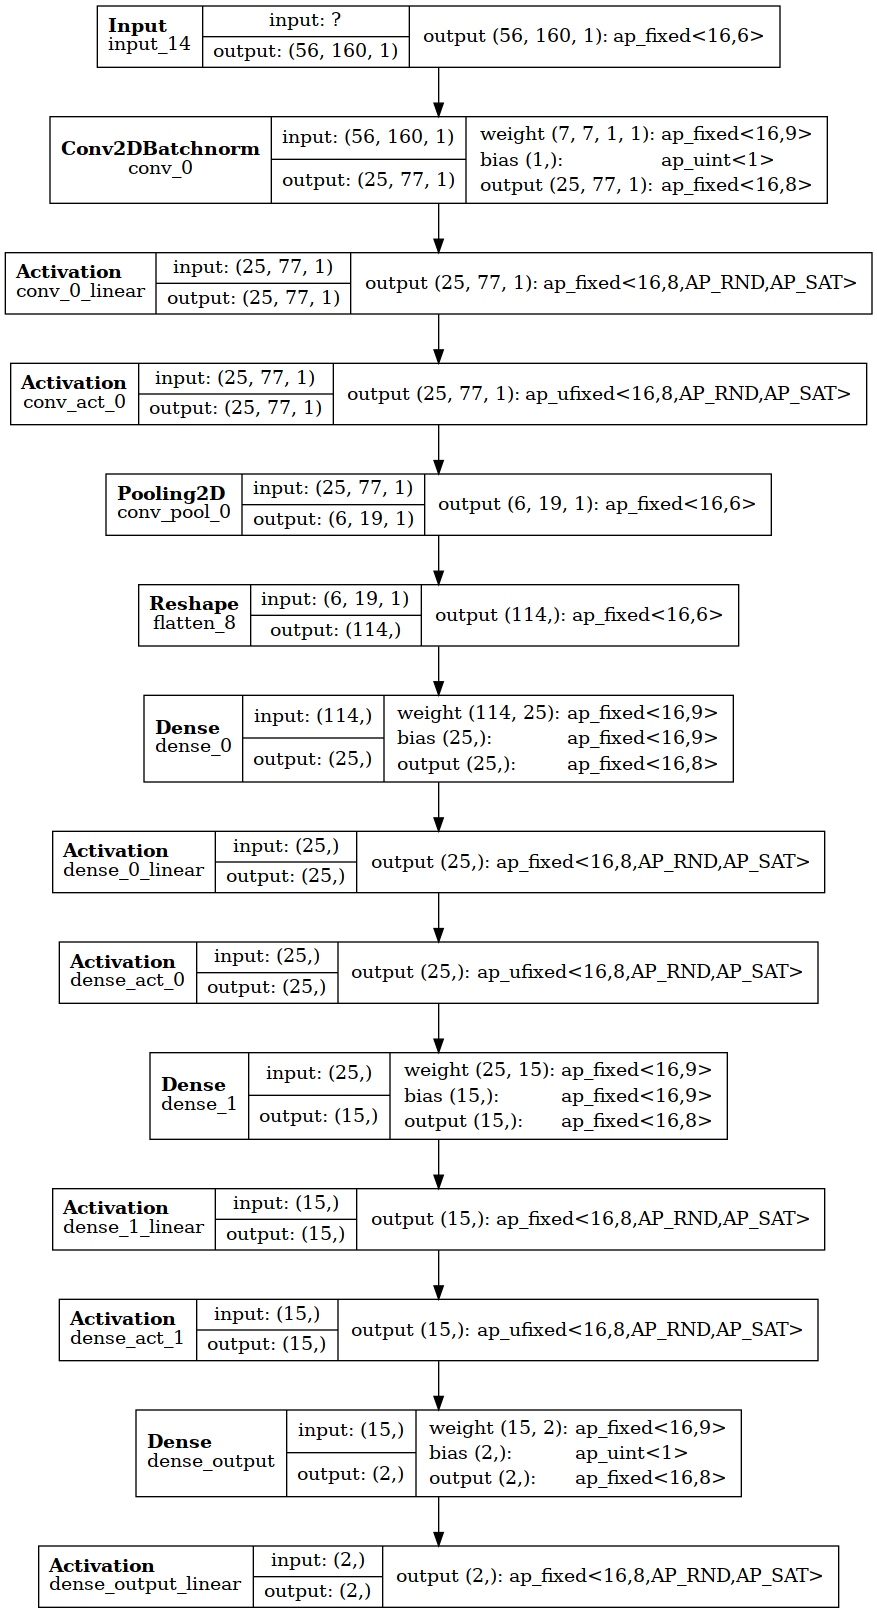

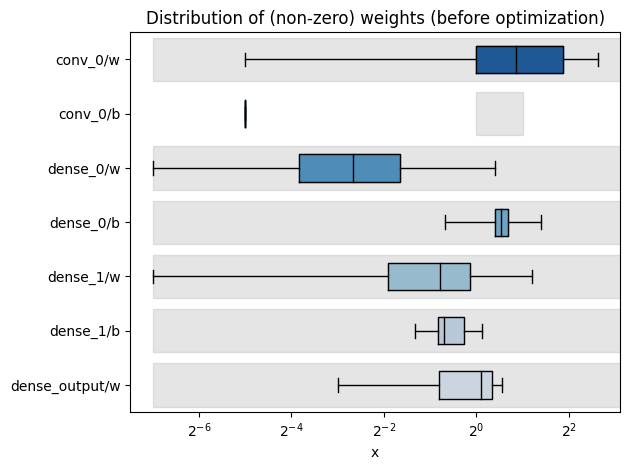

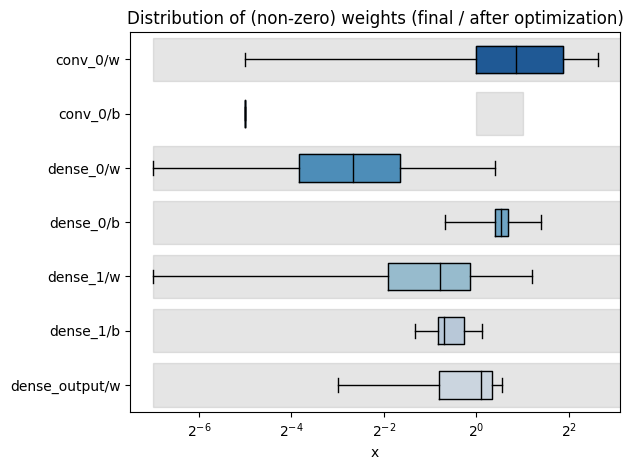

In [77]:

hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

hls_config_q = hls4ml.utils.config_from_keras_model(Qmodel, 
                                                    granularity='name'
                                                   )
hls_config_q['Model']['ReuseFactor'] = 1
hls_config_q['Model']['Precision'] = 'ap_fixed<16,8>'
hls_config_q['LayerName']['dense_output']['Strategy'] = 'Stable'
plotting.print_dict(hls_config_q)
  
cfg_q = hls4ml.converters.create_config(backend='Vivado')
cfg_q['IOType']     = 'io_stream' # Must set this if using CNNs!
cfg_q['HLSConfig']  = hls_config_q
cfg_q['KerasModel'] = Qmodel
cfg_q['OutputDir']  = compile_outdir 
cfg_q['XilinxPart'] = 'xcvu160-flgb2104-2-e'
#cfg_q['XilinxPart'] = 'xcu250-figd2104-2L-e'
  
hls_model_q = hls4ml.converters.keras_to_hls(cfg_q)
hls4ml.model.profiling.numerical(model=Qmodel, hls_model=hls_model_q)
hls4ml.utils.plot_model(hls_model_q, show_shapes=True, show_precision=True, to_file=None) 


## HLS4ML MODEL compile

In [82]:
hls_model_q.compile()

Writing HLS project
Done


## Inference

In [111]:
# inference over all samples
predictions_baseline        = std_model(HIT_IMAGES)
predictions_weightquantized = Qmodel(HIT_IMAGES)
predictions_allquantized = hls_model_q.predict(HIT_IMAGES)

# calculate the deviation
absolute_deviation_baseline        = np.absolute( predictions_baseline - Y)
absolute_deviation_weightquantized = np.absolute( predictions_weightquantized  - Y)
absolute_deviation_allquantized    = np.absolute( predictions_allquantized  - Y)

# error accumulator
error_accmulator_baseline        = [] 
error_accmulator_weightquantized = []  
error_accmulator_allquantized =    []   

# interate over all deivation and calculate the Eucilidan distance
for i,[x_deviation,y_deviation] in enumerate(absolute_deviation_baseline):
    error_accmulator_baseline.append( (x_deviation**2 + y_deviation**2) ** 0.5)

for i,[x_deviation,y_deviation] in enumerate(absolute_deviation_weightquantized):
    error_accmulator_weightquantized.append( (x_deviation**2 + y_deviation**2) ** 0.5)

for i,[x_deviation,y_deviation] in enumerate(absolute_deviation_allquantized):
    error_accmulator_allquantized.append( (x_deviation**2 + y_deviation**2) ** 0.5)

#print(f"Average Error Over all is : {error_accmulator / 45484 } cm")
print(f"Average Distance deviation over all{X.shape[0]} trainng sample:")
print(f"Baseline Model lr:5e-4 ep:600 Ba:50: {sum(error_accmulator_baseline) / len(error_accmulator_baseline)} cm")
print(f"Qkeras Model  lr:2e-5 ep:600 Ba:50 : {sum(error_accmulator_weightquantized) / len(error_accmulator_weightquantized)} cm ")
print(f"FPGA modul : {sum(error_accmulator_allquantized) / len(error_accmulator_allquantized)} cm")

Average Distance deviation over all45484 trainng sample:
Baseline Model lr:5e-4 ep:600 Ba:50: 8.608480109906894 cm
Qkeras Model  lr:2e-5 ep:600 Ba:50 : 7.250871202919005 cm 
FPGA modul : 7.254232485480164 cm


## Build the model

In [87]:
hls_model_q.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2700185 on Thu Oct 24 18:45:48 MDT 2019
  **** IP Build 2699827 on Thu Oct 24 21:16:38 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/xilinx/ISE_EDK/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/tools/xilinx/ISE_EDK/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'updyh' on host 'work5.itiv.kit.edu' (Linux_x86_64 version 4.18.0-425.19.2.el8_7.x86_64) on Sun Apr 23 04:56:35 CEST 2023
INFO: [HLS 200-10] On os "Rocky Linux release 8.7 (Green Obsidian)"
INFO: [HLS 200-10] In directory '/home/updyh/Git/displaced_vertex_cnn_accelerator/cnn_runs/QCNN_HLS4ML_8_0'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/updyh/Git/displaced_vertex_cnn_accelerator/cnn_runs/QCNN_HLS4ML_8_0/myproject_prj'.
INFO: [HL

{'EstimatedClockPeriod': '5.094',
 'BestLatency': '8978',
 'WorstLatency': '8978',
 'IntervalMin': '8967',
 'IntervalMax': '8967',
 'BRAM_18K': '7',
 'DSP48E': '1278',
 'FF': '48958',
 'LUT': '123268',
 'URAM': '0',
 'AvailableBRAM_18K': '6552',
 'AvailableDSP48E': '1560',
 'AvailableFF': '1852800',
 'AvailableLUT': '926400',
 'AvailableURAM': '0'}

hls4ml.report.read_vivado_report(compile_outdir)

In [88]:
hls4ml.report.read_vivado_report(compile_outdir)

Found 1 solution(s) in cnn_runs/QCNN_HLS4ML_8_0//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Sun Apr 23 05:05:57 2023

* Version:        2019.2 (Build 2698951 on Thu Oct 24 19:15:34 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtexu
* Target device:  xcvu160-flgb2104-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 5.094 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+------+------+----------+
    |  Latency (cycles) |   Latency (absolute)  |   Interval  | Pipeline |
    |   min   |   max   |    min    |    max    |  min |  max |   Type   |
    +---------+-----

## plot models

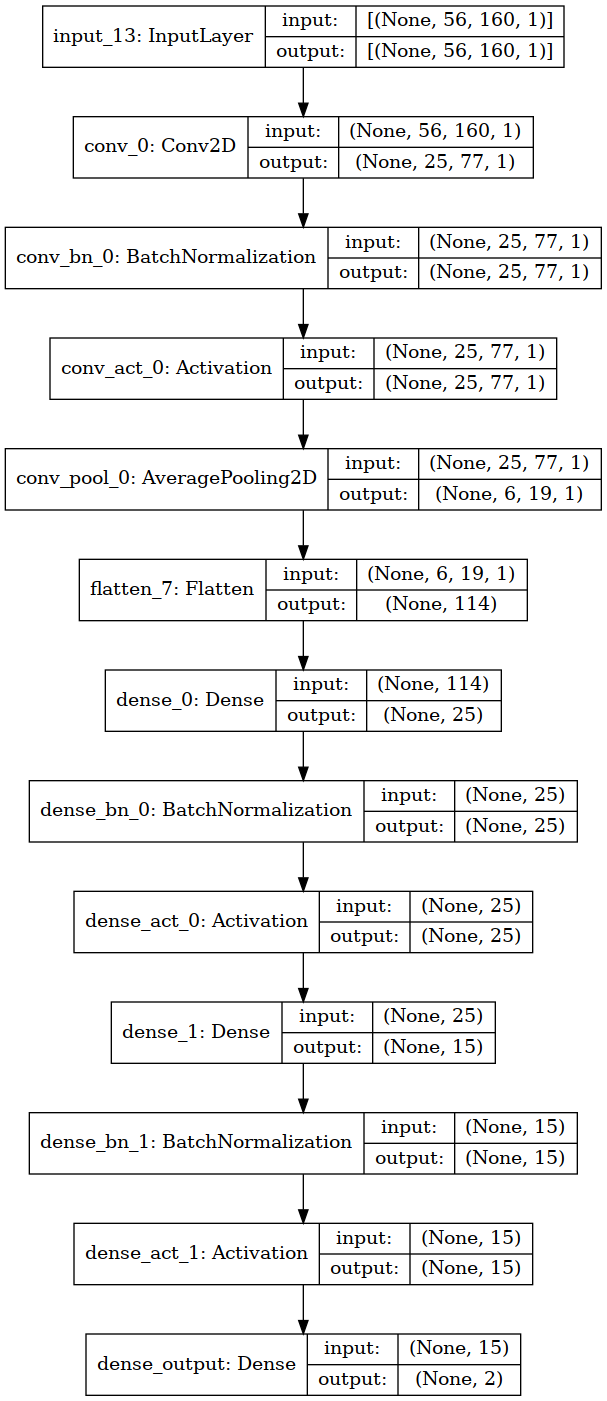

In [92]:
from tensorflow.keras.utils import plot_model
plot_model(std_model,to_file="std_cnn_model.png",show_shapes=True,show_layer_names=True)

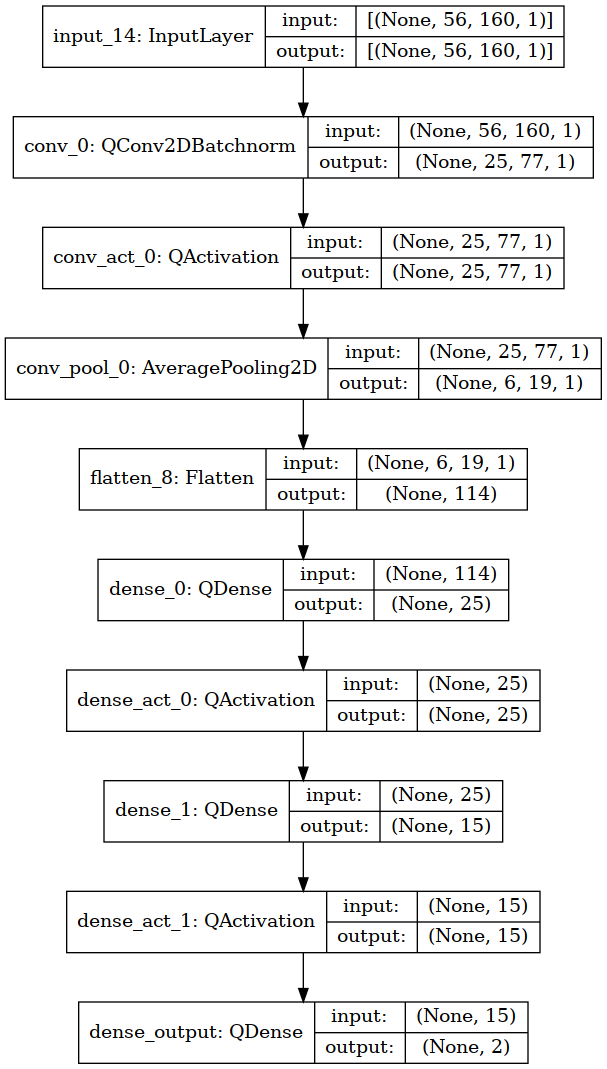

In [91]:
plot_model(Qmodel,to_file="Q_cnn_model.png",show_shapes=True,show_layer_names=True)

## Get to onnx

In [107]:
import keras2onnx
import onnx
import tf2onnx


std_model.save("cnn_runs/ONNX-model/originalmodel/std_8_3_8_9/")

# 获取输入张量的形状
#input_shape = keras_model.input.shape[1:]

# 获取输出张量的名称
#output_names = keras_model.name

# 将Keras模型转换为ONNX格式
#onnx_model = keras2onnx.convert_keras(keras_model, keras_model.name)

# 保存ONNX模型
#keras2onnx.save_model(onnx_model, 'cnn_runs/std_83_89_cnn.onnx')

2023-04-23 06:00:56.332097: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: cnn_runs/ONNX-model/originalmodel/std_8_3_8_9/assets


INFO:tensorflow:Assets written to: cnn_runs/ONNX-model/originalmodel/std_8_3_8_9/assets


In [108]:
!python -m tf2onnx.convert --saved-model cnn_runs/ONNX-model/originalmodel/std_8_3_8_9/ --output cnn_runs/std_cnn8389_model.onnx --opset 13

/home/updyh/miniconda3/envs/hls4ml-tutorial/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-04-23 06:02:35,796 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-04-23 06:02:36,154 - INFO - Signatures found in model: [serving_default].
2023-04-23 06:02:36,154 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-04-23 06:02:36,154 - INFO - Output names: ['dense_output']
2023-04-23 06:02:36,299 - INFO - Using tensorflow=2.4.0, onnx=1.13.0, tf2onnx=1.14.0/8f8d49
2023-04-23 06:02:36,299 - INFO - Using opset <onnx, 13>
2023-04-23 06:02:36,308 - INFO - Computed 0 values for constant folding
2023-04-23 06:02:36,325 - INFO - Optimizing ONNX model
2023-04-23 06:02:36,466 - INFO - After optimization: BatchNormalization -1 (1->0), Cast -1 (1->0), Cons

In [109]:
import netron
netron.start("cnn_runs/std_cnn8389_model.onnx")

Serving 'cnn_runs/std_cnn8389_model.onnx' at http://localhost:8080


('localhost', 8080)

import n